In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [1]:
# fetch the dataset

In [2]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()

In [3]:
## data viz

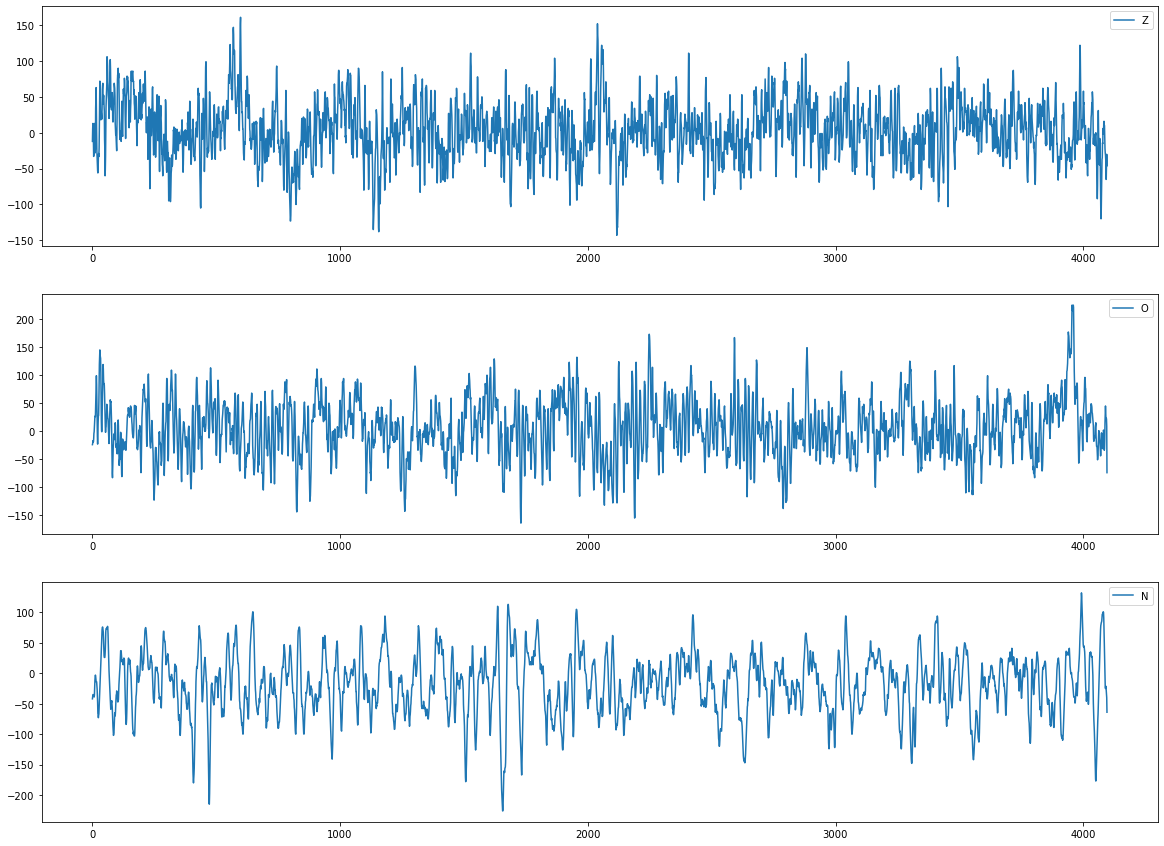

In [70]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(eeg['measurements'][50])
plt.legend(eeg['classes'][50])
plt.subplot(3,1,2)
plt.plot(eeg['measurements'][199])
plt.legend(eeg['classes'][199])
plt.subplot(3,1,3)
plt.plot(eeg['measurements'][200])
plt.legend(eeg['classes'][200])

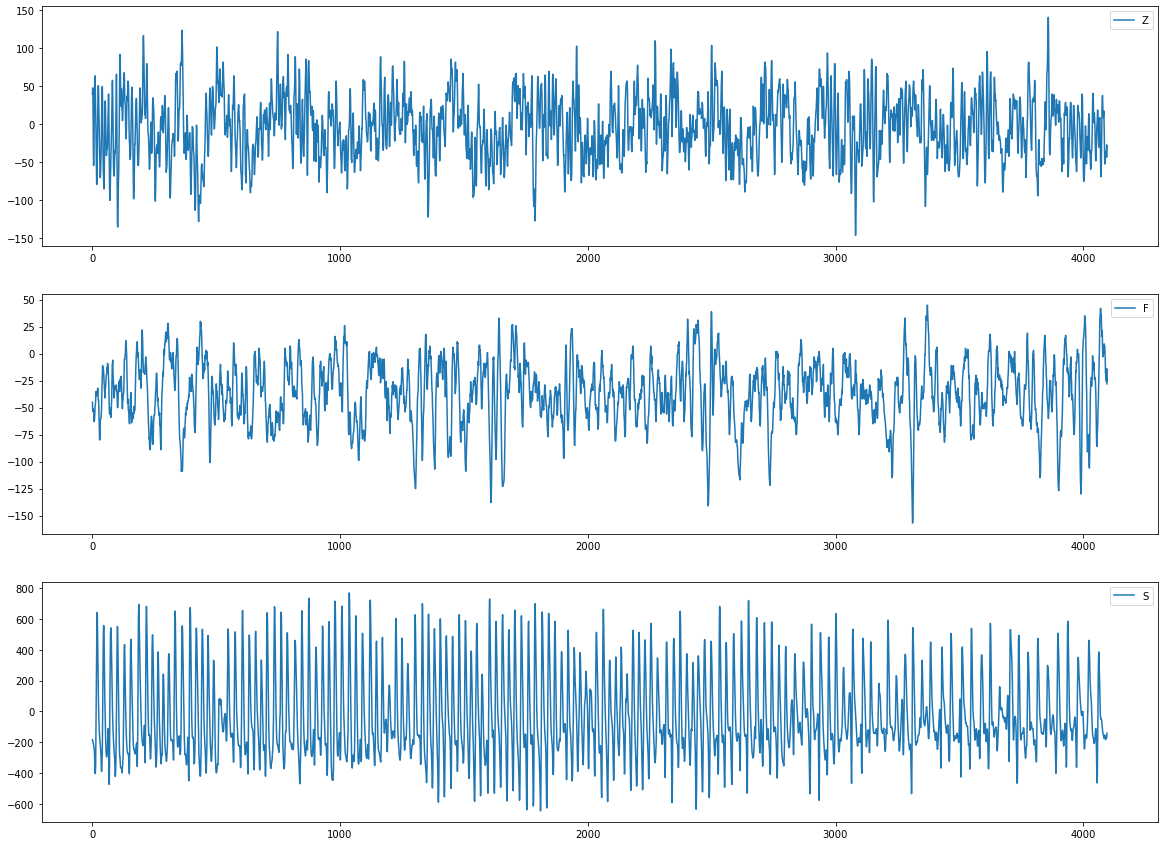

In [9]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.plot(eeg['measurements'][0])
plt.legend(eeg['classes'][0])
plt.subplot(3,1,2)
plt.plot(eeg['measurements'][300])
plt.legend(eeg['classes'][300])
plt.subplot(3,1,3)
plt.plot(eeg['measurements'][450])
plt.legend(eeg['classes'][450])

In [ ]:
## we plot 3 randomly selected samples from EEG dataset
## shows differecnces between classes of EEG measurement (activites of brain)
## each is an independent timeseries measurement taken from a differernt patient at different time

In [10]:
## class G and F seem to have less skewed data than class S
## each class has quite a different range of values ,, this sugegst that an amplitude feature could be useful

In [22]:
import cesium.featurize as ft

In [23]:
features_to_use = ['amplitude','percent_beyond_1_std',
                  'percent_close_to_median','skew','max_slope']
fset_cesium = ft.featurize_time_series(times = eeg['times'],
                values = eeg['measurements'],
                errors = None,
                features_to_use = features_to_use,
                scheduler = None)


In [25]:
fset_cesium.head() ## Numerical features we have generated for the first few sample in our dataset

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


In [26]:
# 500 obesrvations
## the values are not normalized, may be we do have to 


500

In [29]:
## let us verify if the feature generated makes sense

In [56]:
stdev = np.std(eeg['measurements'][0])

In [57]:
mean = np.mean(eeg['measurements'][0])

In [53]:
sample_ts = eeg['measurements'][0]
sz = len(sample_ts)

In [58]:
ll = mean-stdev
ul = mean+stdev

In [59]:
quals = [i for i in range(sz) if sample_ts[i]<ll or sample_ts[i]>ul]

In [62]:
len(quals)/sz ## thus we can varify

0.3273126678057115

In [63]:
## while choosing the features, the values of the fetures selected should converge to a stable value as more data
##from the same process will be colected -- else it is the case of random wlak for which the measurement of mean of the 
## process is meaningless and will not be erdogic.
## the mean of random wlak shoulf not converge to a specific value 

In [64]:
## using RandomforestClassifiecation and XGBoost to classify the EEG data based on the features we generated

### RandomForest and XGBoost

In [65]:
from sklearn.model_selection import train_test_split

In [71]:
X_train,X_test,y_train,y_test = train_test_split(fset_cesium.values,eeg['classes'],random_state=21)

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
rf_clf = RandomForestClassifier(n_estimators=10,max_depth=3,random_state=21)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [75]:
## out-of-sample_accuracy
rf_clf.score(X_test,y_test)

0.616

In [76]:
## better than non-mdeical background human can predict,, also this model we have trained 
# sees on the summary statics not the enite EEG

In [79]:
import xgboost as xgb

In [80]:
xgb_clf = xgb.XGBClassifier(n_estimators=10,max_depth=3, random_state=21)

In [81]:
xgb_clf.fit(X_train,y_train)

[11:17:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
xgb_clf.score(X_test,y_test)

0.688

In [83]:
## does slightly better than randomforest classifier
## also trains faster than rfc

In [86]:
%%time
xgb_clf.fit(X_train,y_train)

[11:19:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 135 ms, sys: 19.6 ms, total: 155 ms
Wall time: 80.7 ms


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
%%time
rf_clf.fit(X_train,y_train)

CPU times: user 29.6 ms, sys: 3.51 ms, total: 33.1 ms
Wall time: 32.4 ms


RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [92]:
import time

In [94]:
start = time.time()
rf_clf.fit(X_train,y_train)
end= time.time()
end-start


0.02824687957763672

In [95]:
start = time.time()
xgb_clf.fit(X_train,y_train)
end= time.time()
end-start

[11:23:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.07561707496643066

In [96]:
## let us decrese the complexity by reducing the number of depth but keeping the number oftrees the same

In [97]:
rf_clf = RandomForestClassifier(n_estimators=10,max_depth=2,random_state=21)
rf_clf.fit(X_train,y_train)
rf_clf.score(X_test,y_test)

0.544

In [98]:
xgb_clf = xgb.XGBClassifier(n_estimators=10,max_depth=2,random_state=21)
xgb_clf.fit(X_train,y_train)
xgb_clf.score(X_test,y_test)

[11:29:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.696

In [99]:
## this is even true if we redcure the complexity futther
rf_clf = RandomForestClassifier(n_estimators=10,max_depth=1,random_state=21)
rf_clf.fit(X_train,y_train)
rf_clf.score(X_test,y_test)

0.376

In [100]:
xgb_clf = xgb.XGBClassifier(n_estimators=10,max_depth=1,random_state=21)
xgb_clf.fit(X_train,y_train)
xgb_clf.score(X_test,y_test)

[11:30:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.64

In [101]:
## this shows that boosting(xgb) is better to bagging(randomforest) when we donot know if the features we have used 
# is really important ,, because bagging will use all the feautres whether it is important or not
## but boosting will likely to ignore useless features -- although use all feautres -- will previlage the relevenat one

In [102]:
## Boosting - better for large (time-series) datsets 


In [104]:
## although XGboost seems to outperform many traditional statistical models,, two major caosiderations are:
## selecmting useful fetures 
## tuning the parameters of the model

## advantages of XGboot method: "auto-piloting"
## -- weed out irrelevant or noisy features and focus on the most important ones


## look at the mislabeled data and try to generate/add those featues that might best describe the mislabeled data 

### Clustering

In [105]:
## data points that are similar to one another constitude meaningful groups for purpose of analysis 

In [106]:
## clustering for time series can be used for both for classification and forecasting

In [112]:
## Forecasting using clustering

## mehtod 1:  use class membership to generate a forecast based on typical behaviour of that class 
## method2 : predict future behaviuor of a sample timeseries based on a behaviour of nearest neighbor in the sample space 


In [108]:
## distance metrics used in time series:
#
#1. distance based on feaures 
##2. similarities based on raw temporal data :  2 timeseires should handle different temporal scale, diff units of measurement
## and other disparities between time series dta

#### Distance btween time series datasets based on the similarity of the features

In [156]:
raw_data = pd.read_csv('dataset/FiftyWords_TRAIN.txt',sep=" ",skipinitialspace=True,header=None)

In [157]:
test_data = pd.read_csv('dataset/FiftyWords_TEST.txt',sep=" ", skipinitialspace=True, header=None)
words_test = pd.DataFrame(test_data)
words_test.shape


(455, 271)

In [158]:
words_test.head()

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,4.0,-0.890942,-0.860995,-0.824383,-0.782136,-0.735733,-0.686906,-0.637538,-0.589371,-0.543422,...,-0.863088,-0.867915,-0.872706,-0.878459,-0.885916,-0.896189,-0.907832,-0.919418,-0.930178,-0.939390
1,12.0,-0.783462,-0.685617,-0.584090,-0.479456,-0.373979,-0.270075,-0.172249,-0.087463,-0.019191,...,-0.883177,-0.891895,-0.902895,-0.914267,-0.926679,-0.939662,-0.952445,-0.966233,-0.980498,-0.991776
2,13.0,-1.325568,-1.284301,-1.219683,-1.156749,-1.099784,-1.049563,-1.015452,-0.996718,-0.985036,...,-0.834992,-0.862044,-0.885588,-0.904536,-0.933529,-0.991349,-1.069073,-1.136841,-1.197966,-1.269968
3,23.0,-1.093671,-1.041959,-0.998400,-0.959970,-0.939970,-0.937637,-0.926489,-0.857090,-0.693318,...,-0.728100,-0.745120,-0.763757,-0.780677,-0.805933,-0.843500,-0.895309,-0.960517,-1.050865,-1.128298
4,4.0,-0.901379,-0.852280,-0.801957,-0.749324,-0.692982,-0.633165,-0.570379,-0.506921,-0.446042,...,-0.954519,-0.973216,-0.989844,-1.005241,-1.018838,-1.029610,-1.036981,-1.041109,-1.041833,-1.040316


In [159]:
words = pd.DataFrame(raw_data)
words.head()

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,9.0,-0.790419,-0.765171,-0.733542,-0.699633,-0.667740,-0.638633,-0.611808,-0.587282,-0.564301,...,-0.592322,-0.621745,-0.654709,-0.690325,-0.727638,-0.764249,-0.794860,-0.814730,-0.822708,-0.821335
1,18.0,-0.764061,-0.744448,-0.743794,-0.720950,-0.717986,-0.702817,-0.691825,-0.680799,-0.671426,...,-0.528000,-0.453934,-0.365317,-0.311797,-0.336820,-0.429081,-0.534639,-0.629839,-0.711351,-0.774474
2,1.0,-0.817041,-0.733105,-0.627820,-0.495715,-0.334888,-0.143279,0.077817,0.322732,0.586229,...,-0.905360,-0.909609,-0.914889,-0.921817,-0.931149,-0.942135,-0.952195,-0.959054,-0.961743,-0.960863
3,5.0,-1.103800,-1.071184,-1.024899,-0.967286,-0.905158,-0.844317,-0.783511,-0.720846,-0.658545,...,-0.953409,-0.974656,-1.000649,-1.031489,-1.064847,-1.095615,-1.119025,-1.132397,-1.135890,-1.132663
4,4.0,-0.435999,-0.316359,-0.211705,-0.114854,-0.019499,0.070713,0.143294,0.193429,0.226835,...,-0.049013,-0.163001,-0.264176,-0.348394,-0.408835,-0.446383,-0.475579,-0.516469,-0.579940,-0.650409


In [160]:
words.shape

(450, 271)

(array([19., 72., 28., 46., 30., 17., 16., 18., 10., 13.]),
 array([-1.5067266 , -1.11100511, -0.71528362, -0.31956213,  0.07615936,
         0.47188085,  0.86760234,  1.26332383,  1.65904532,  2.05476681,
         2.4504883 ]),
 <a list of 10 Patch objects>)

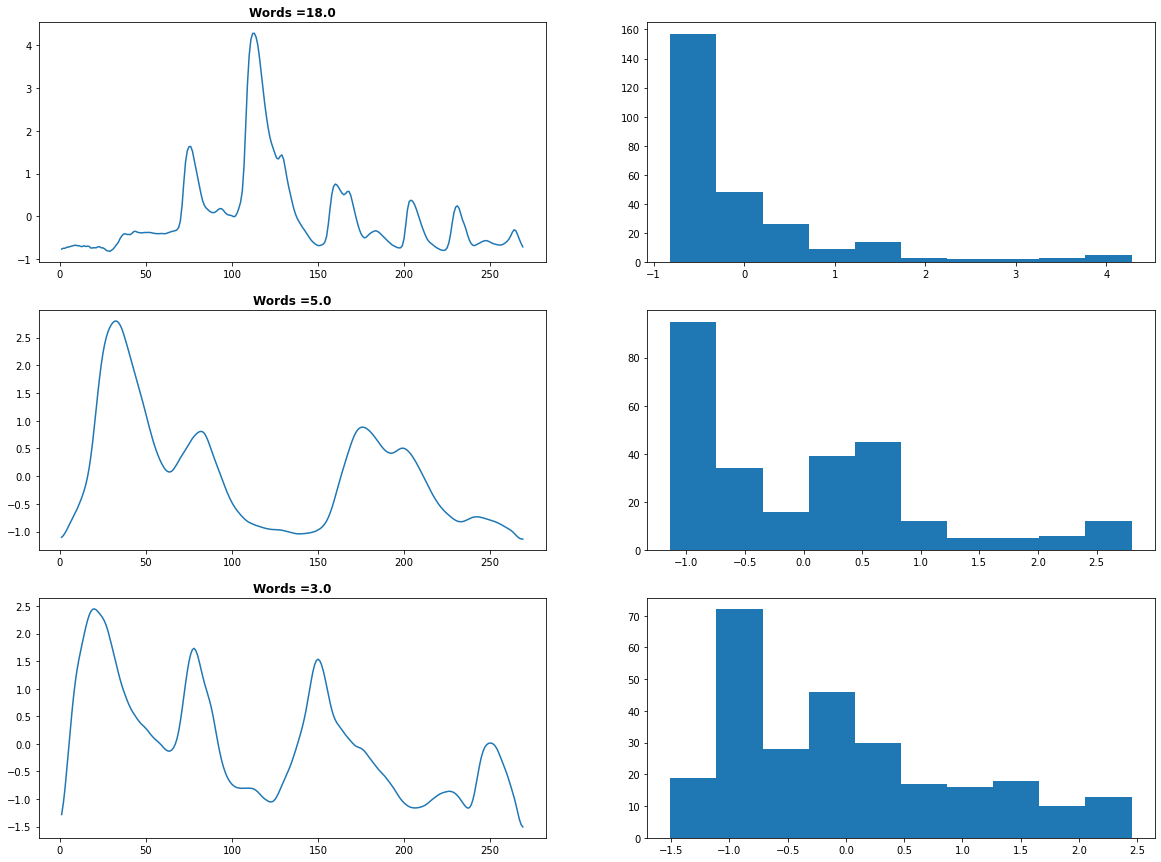

In [161]:
## PLOTTING THE DATA
    
plt.figure(figsize=(20,15))
plt.subplot(3,2,1)
plt.plot(words.iloc[1,1:-1])
plt.title("Words ="+str(words.iloc[1,0]),fontweight='bold')
plt.subplot(3,2,2)
plt.hist(words.iloc[1,1:-1],10)
plt.subplot(3,2,3)
plt.plot(words.iloc[3,1:-1])
plt.title("Words ="+str(words.iloc[3,0]),fontweight='bold')
plt.subplot(3,2,4)
plt.hist(words.iloc[3,1:-1],10)
plt.subplot(3,2,5)
plt.plot(words.iloc[5,1:-1])
plt.title("Words ="+str(words.iloc[5,0]),fontweight='bold')
plt.subplot(3,2,6)
plt.hist(words.iloc[5,1:-1],10)


In [162]:
## to make sure the words we are looking for is not outliers, let make 2d histogram for two words and see the
## individual variation

In [163]:
x = np.array([])
y = np.array([])

w = 12
selected_words=words[words.iloc[:,0]==w] ## select all rows that have value value for word =12
selected_words.shape


(13, 271)

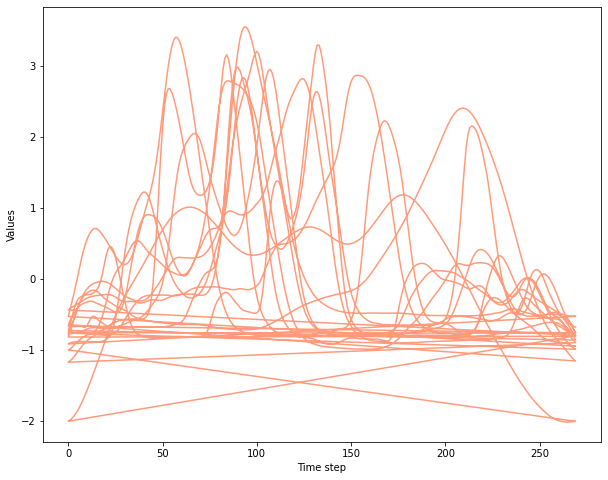

In [164]:
## distribution of word 12

for idx,rows in selected_words.iterrows():
    y = np.hstack([y,rows[1:271]])
    x = np.hstack([x, np.array(range(270))]) # for index

plt.figure(figsize=(10,8))
plt.plot(x,y,alpha=0.6,color='#FF5722')
plt.xlabel('Time step')
plt.ylabel('Values')
plt.show()

In [165]:
## 2D- histogram for 1-D word projection for word =12
## y-axis is a value at a given time step
## x-axis represent 270 timestep for each time series sample


## shows that most of word 12 has these falt span between these peaks (between 120-200 )rather than what we have thought of for the
## single word 12 just by looking at the single observation of word

In [166]:
## this suggest the flat span word be a good feature rather than the two peaks we have seen earlier 
## this is based on the intensity of curves being intersected at these regions

# here we see maximum peaks mainly lie between the reigon of 50 and 150
## we could even use the feature that corresponds to maximum peak value between 50 and 150

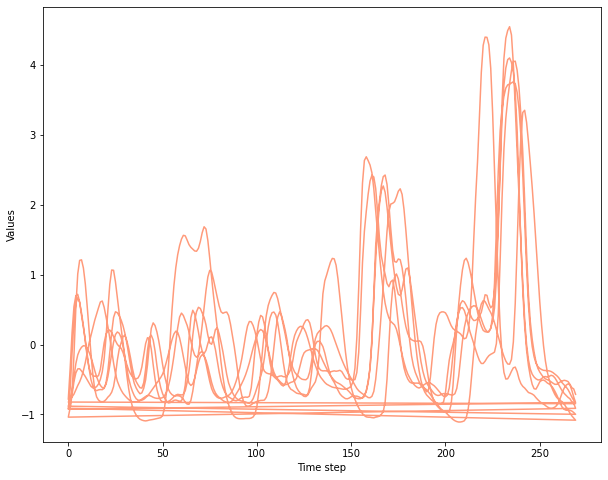

In [167]:
## distribution of word 23
## A 2D histogram of 1D projection of word 23 
x = np.array([])
y = np.array([])

w = 23
selected_words=words[words.iloc[:,0]==w] ## select all rows that have value value for word =12
selected_words.shape

for idx,rows in selected_words.iterrows():
    y = np.hstack([y,rows[1:271]])
    x = np.hstack([x, np.array(range(270))]) # for index

plt.figure(figsize=(10,8))
plt.plot(x,y,alpha=0.6,color='#FF5722')
plt.xlabel('Time step')
plt.ylabel('Values')
plt.show()

In [168]:
## there are many smaller bumps ,,, thus the feature is difficult to qunatize
## we have already seen the hist for single word 23 above and it looked jagged as well 
## maximum value for the peak comes after 150

In [169]:
## The 2d histogram are helpful in letting us know the variablity of features within the individual class,, so that we
## do not rely on single class examples when thinking about how to form our features

In [170]:
## since too many jagged/smears appeared,, we rely on two features-- one from the histogram and the other from the 
## projection itself -- this is more reliable and charateristic than word projection itself

In [171]:
## Histogram give the sense of what kind of values appear in the distribution rather than where it appers (location)

### let us now generate the features

In [172]:
import cesium.featurize as ft

In [173]:
word_vals = words.iloc[:,1:271]
times = []
word_values = []

for idx,row in word_vals.iterrows():
    word_values.append(row.values) #word value rows contain data for each number 
    times.append(np.array([i for i in range(row.values.shape[0])])) ## for each row give time from 0 to 269


In [81]:
features_to_use = ['amplitude','percent_beyond_1_std','percent_close_to_median']
featurized_words = ft.featurize_time_series(times=times,
                                            values=word_values,
                                            errors=None,
                                            features_to_use=features_to_use,
                                            scheduler=None
                                           )

In [111]:
featurized_words.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median
channel,0,0,0
0,1.674549,0.188889,0.451852
1,1.990515,0.118519,0.259259
2,2.903646,0.114815,0.637037
3,2.515061,0.211111,0.562963
4,1.966152,0.181481,0.533333


In [83]:
## let us create a histogram and use these as another timeseries for which to generate features
## i.e create some features deried from histogram

In [109]:
word_features = words.iloc[:,1:271]
times=[]
hist_values = []

for idx,row in word_features.iterrows():
    hist_values.append(np.histogram(row.values, bins=10, range=(-2.5,5))[0]+0.0001) # 0s cause downstream problems
    times.append(np.array([i for i in range(9)])) # since 10 bins

# here we made sure all values we are looking for generates the histogram with the same range of values
## and same number of bins, thus are comparable to each other
## np.HISTOGRAM generates to array,, one for density represented in y-axis and x-axis as the range (-2.5 to 5 ) and interval of 10
features_to_use = ['amplitude','percent_close_to_median','skew']

featuried_hists = ft.featurize_time_series(times=times,
                                          values=hist_values,
                                          errors=None,
                                          features_to_use=features_to_use,
                                          scheduler=None)


    
    

In [112]:
featuried_hists.head()

feature,amplitude,percent_close_to_median,skew
channel,0,0,0
0,88.0,0.444444,2.262655
1,61.0,0.666667,1.285343
2,70.0,0.666667,1.683031
3,67.0,0.555556,1.724109
4,75.0,0.777778,1.902513


In [174]:
## generate features for test set

In [175]:
word_vals_test = words_test.iloc[:,1:271]
times_test = []
word_values_test = []

for idx,row in word_vals_test.iterrows():
    word_values_test.append(row.values) #word value rows contain data for each number 
    times_test.append(np.array([i for i in range(row.values.shape[0])])) ## for each row give time from 0 to 269


In [176]:
features_to_use = ['amplitude','percent_beyond_1_std','percent_close_to_median']
featurized_words_test = ft.featurize_time_series(times=times_test,
                                            values=word_values_test,
                                            errors=None,
                                            features_to_use=features_to_use,
                                            scheduler=None
                                           )

In [177]:
word_features_test = words_test.iloc[:,1:271]
times_test = []
hist_values_test = []

for idx,row in word_features_test.iterrows():
    hist_values_test.append(np.histogram(row.values, bins=10, range=(-2.5,5))[0]+0.0001) # 0s cause downstream problems
    times_test.append(np.array([i for i in range(9)])) # since 10 bins

# here we made sure all values we are looking for generates the histogram with the same range of values
## and same number of bins, thus are comparable to each other
## np.HISTOGRAM generates to array,, one for density represented in y-axis and x-axis as the range (-2.5 to 5 ) and interval of 10
features_to_use = ['amplitude','percent_close_to_median','skew']

featuried_hists_test = ft.featurize_time_series(times=times_test,
                                          values=hist_values_test,
                                          errors=None,
                                          features_to_use=features_to_use,
                                          scheduler=None)


    
    

In [178]:
features_test = pd.concat([featurized_words_test.reset_index(drop=True),featuried_hists_test],axis=1)

In [108]:
## to see what np.histogram returns

word_features = words.iloc[:,1:271]

np.histogram(word_features.iloc[1,:], bins=10, range=(-2.5,5))

(array([  0,   0, 122,  91,  32,   5,  11,   9,   0,   0]),
 array([-2.5 , -1.75, -1.  , -0.25,  0.5 ,  1.25,  2.  ,  2.75,  3.5 ,
         4.25,  5.  ]))

In [113]:
## finally we combine these two sources of features

features = pd.concat([featurized_words.reset_index(drop=True),featuried_hists],axis=1)

In [114]:
features.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,amplitude,percent_close_to_median,skew
channel,0,0,0,0,0,0
0,1.674549,0.188889,0.451852,88.0,0.444444,2.262655
1,1.990515,0.118519,0.259259,61.0,0.666667,1.285343
2,2.903646,0.114815,0.637037,70.0,0.666667,1.683031
3,2.515061,0.211111,0.562963,67.0,0.555556,1.724109
4,1.966152,0.181481,0.533333,75.0,0.777778,1.902513


In [100]:
words.describe()

,0,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,13.681319,-0.968103,-0.885007,-0.778120,-0.654555,-0.525389,-0.400123,-0.283880,-0.176247,-0.076164,...,-0.760276,-0.789874,-0.822035,-0.855764,-0.890788,-0.927284,-0.962613,-0.993350,-1.020232,-1.044678
std,13.636307,0.299395,0.322898,0.365436,0.458092,0.570405,0.678534,0.776815,0.864609,0.943802,...,0.359299,0.345614,0.329948,0.317965,0.311813,0.303525,0.300682,0.315002,0.317510,0.279692
min,1.000000,-2.449009,-2.325484,-2.139497,-2.113569,-2.091152,-2.060984,-2.023024,-1.981644,-1.900970,...,-2.182068,-2.195612,-2.218630,-2.321678,-2.405636,-2.467087,-2.505301,-2.522016,-2.520756,-2.509482
25%,3.000000,-1.092708,-1.043211,-0.982456,-0.927736,-0.891011,-0.854716,-0.830724,-0.794414,-0.761910,...,-0.921416,-0.940886,-0.958808,-0.978155,-1.020051,-1.046371,-1.087825,-1.124609,-1.145696,-1.173393
50%,8.000000,-0.926157,-0.860995,-0.796691,-0.722616,-0.668978,-0.583339,-0.527961,-0.442422,-0.379612,...,-0.780792,-0.798022,-0.817112,-0.839355,-0.858868,-0.882733,-0.911612,-0.937005,-0.959826,-0.989037
75%,21.500000,-0.803077,-0.722130,-0.636539,-0.480468,-0.313768,-0.132962,0.079385,0.277993,0.468085,...,-0.642551,-0.666543,-0.691956,-0.717829,-0.738773,-0.770033,-0.790859,-0.820513,-0.849909,-0.869747
max,50.000000,2.023118,2.400979,1.675694,1.640967,2.606174,3.416426,3.993529,4.347660,4.506258,...,1.310795,1.417946,1.368805,1.521548,1.805415,1.669995,1.571191,2.229690,2.362549,0.499401


In [91]:
data_desc = pd.DataFrame(words.describe())

In [102]:
data_desc.iloc[7,1:].max()

5.281285

In [103]:
data_desc.iloc[3,1:].min()

-2.5220157000000003

In [104]:
## thus better to create histogram from -2.5 to 5

#### Distance Metric for Clustring a time series

In [116]:
# Dynamic Time Warping (DTW) = approprite to measure similarity between time seires whose most salient features is its
# overall shape -- as is the case with our word projection data

## in this technique,, the temporal(x-axis) is warped (expanded or contracted) to find the best alignment of points
## between the two time series curve 

## point in one time series is mapped to another time seires --- length need not be same, nor does the timescale
## the only thing that matters is the shape (the mapping need not be 1-to-1 mapping)

## main purpose of the algo is comapring the visual shape rather than how much time has elapsed

## time is ordered evenly spaced points in the x-axis rather than the actual time

In [117]:
## Rules: 
## at least one matching point for the current time series with the one being compared
## the first and last indices must alingn/match with their counterpart in the other time series
## the mapping of points must be such that time moves forward not backward .. but time does not have to move forward 
# constantly


## selected match is the one that minized the distance between the curves 
## distance = sum of absoulte diffrence between the matched point

In [137]:
## method to calculate the DTW

def distDTW(ts1,ts2):
    ## this is setup
    DTW={}
    for i in range(len(ts1)):
        DTW[(i, -1)] = np.inf
    for i in range(len(ts2)):
        DTW[(-1, i)] = np.inf
    DTW[(-1, -1)] = 0
    
    ##this is whre we actually calculate the optimum
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts[i]-ts[j])**2
            DTW[(i, j)]= dist+ min(DTW[(i-1,j)],
                                  DTW[(i,j-1)],
                                  DTW[(i-1,j-1)]) ## this is the example of dymanic programming
    ## once we found the complete paht we return the associated distance
    return np.sqrt(DTW[(len(ts1)-1, len(ts2)-1)]) ## last value of the dict
            

In [138]:
#let us use the selected features and pairwise DTW distance metric to perfrom clustering and compare the results 

#### Hierarchical Clustering of normalized features

In [140]:
## since our original feature and feature generated from histogram are in different, it is wiser to normalize the values
## as we wish to apply single distance metric to them

In [141]:
from sklearn import preprocessing

In [142]:
feature_values = preprocessing.scale(features.values)

In [143]:
## we select hierarchichl clustering algorithm and perform a fit for 50 clusters , since we are seeking to match
# these clusters to the 50 words in our data set:

In [144]:
from sklearn.cluster import AgglomerativeClustering

In [145]:
words.shape

(455, 271)

In [179]:
p = preprocessing.scale(features_test.values)

In [180]:
feature_clustering = AgglomerativeClustering(n_clusters=50, linkage='ward')
feature_clustering.fit(feature_values)# fit the normalized features
words_test['feature_labels'] = feature_clustering.fit_predict(p)

In [181]:
from sklearn.metrics.cluster import homogeneity_score

In [187]:
homogeneity_score(words_test.iloc[:,0],words_test['feature_labels'])

0.5085776345414814

In [188]:
## since we are working with labeled data,, we  might otherwise draw incorrect infrmation based the cluster we formed

In [189]:
## how to improve the performance:

## use more features,,, here we used only 6 features
## look for features that are relatibely uncorrelated
## may be we did not include some useful feautres,, like the distinctive peaks in the diagram could be useful features
## can use other distance metrics,, perhaps some that would weight certain features more strongly than others ,, privileging
## the features which human eye find useful

#### Hierarchichal Clustering with DTW distance metric

In [190]:
## this is computationally taxing ,,thus we better save the result 